In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm
import rasterio
import rasterio.plot as rplt
from rasterio.merge import merge
from rasterio.mask import mask
from rasterio.windows import Window as rWindow
from rasterio.enums import Resampling
from matplotlib_scalebar.scalebar import ScaleBar


from typing import List, Any
import os
#import cv2
import pyproj
import pandas as pd

In [2]:
import sgl_processor_v03 as sgl # type: ignore
import sgl_utils # type: ignore
import geopandas as gpd
settings = sgl.ProcessorSGLSettings()
settings.rangestart = "20191201"
settings.rangeend = "20200331"
processorSGL = sgl.initialize(settings)
metas = sgl.get_metadata_from_csv(settings.season_folder, ["tile-181", "tile-182", "tile-183"])
coll = sgl.create_collection_from_meta(settings, "shackleton1920", metas)

X=====================================================
SGLProcessor started for 20191201 to 20200331
X=====================================================
=====> Get metadata from .csv files.
=====> Create collection from csv meta.
     | 69 windows created for collection.


In [7]:
#files = os.listdir(os.path.join(processorSGL.opts.parent_input_folder, "shapefiles"))
#roi_shapefiles = [f for f in files if f.split("_")[0].split("-")[0] == "shackleton" and len(f.split("_")[0]) > len("shackleton") and f.split(".")[-1] == "shp"]
#processorSGL.create_roi_csv(roi_shapefiles)
rcoll = sgl.create_roicollection_from_csv(settings, name = "shackleton")
#sgl.add_roi_statistics(settings, rcoll, coll, print_metadata = False, update_bool = True)

=====> Get ROICollection from csv roi.csv
     | 16 regions created.


In [9]:
ice_shelf = r"D:\[NOT SYNC]\ASRP_Data\shackleton\ice_shelves.geojson"
ice = gpd.read_file(ice_shelf).to_crs(settings.crs_ant_str)

In [13]:
lakeextents = sgl.get_vectorized_lakeextents(settings.season_folder, coll, print_bool = True)
    

=====> Get vectorized max lake extents.
     |  33843 | tile-181_L8S2_2019-12-01_2020-03-31_10m_maxlake.tif
     |   8342 | tile-182_L8S2_2019-12-01_2020-03-31_10m_maxlake.tif
     |   2474 | tile-183_L8S2_2019-12-01_2020-03-31_10m_maxlake.tif


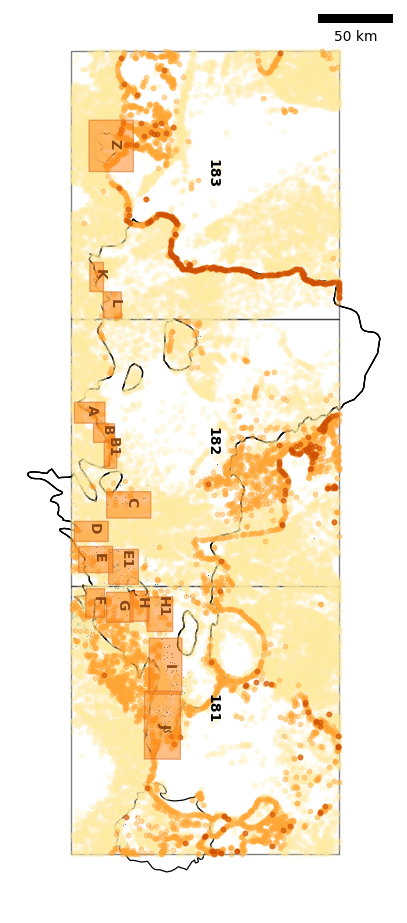

In [15]:
cmap = cm.get_cmap('YlOrBr', 100)

fig, ax = plt.subplots(figsize = (5, 15))
for i, name in enumerate(coll.names):
    """Tiles"""
    tile = gpd.read_file(os.path.join(processorSGL.opts.parent_input_folder, 'shapefiles', name + '_shape.shp')).to_crs(pyproj.CRS(processorSGL.opts.crs_ant_str))
    tile.plot(ax = ax, facecolor="none", alpha = 0.5, edgecolor = "black")

    """Max Lake Extents"""
    lakeextent = [extent for extent in lakeextents if extent["file"].split("_")[0] == name][0]  # type: ignore
    lakeextent["data"].plot(ax = ax, facecolor="tab:blue")  # type: ignore

    """Damage"""
    #dmg = [d for d in dmgs if d["file"].split("_")[0] == name][0]  # type: ignore
    #dmg["data"].plot(ax = ax, facecolor="tab:red", alpha = 0.6)  # type: ignore

    """Ice Shelf"""
    ax.text(tile.centroid.x, tile.centroid.y, name.split("-")[-1], rotation = -90, fontweight = "bold")
    xmin, ymin, xmax, ymax = tile.total_bounds
    ice_window = ice.cx[xmin:xmax, ymin:ymax]
    ice_window.plot(ax = ax, facecolor="none", edgecolor='black', lw=0.9)

    """
    with rasterio.open(os.path.join(processorSGL.opts.input_dmg_folder, name + '_S1_20191101_20191110_30m_output_10px_dmg.tif')) as src:
        #lake_extent_clipped, lake_extent_transform = mask(dataset=src, shapes=[geom for geom in tile["geometry"]], crop=True)
        dmg = src.read(1)
        dmg_transform = src.transform
        dmg_meta = src.meta
    
    dmg = np.nan_to_num(dmg, nan = 0)

    factor = 10
    hs = np.arange(0, dmg_meta["height"], factor)
    ws = np.arange(0, dmg_meta["width"], factor)
    dmg_coarse = np.zeros((hs.size-1, ws.size-1))
    for i, h in enumerate(hs):
        for j, w in enumerate(ws):
            if i > 0 and j > 0:
                dmg_coarse[i-1, j-1] = dmg[hs[i-1]:h, ws[j-1]:w].sum()
                #print(f"{hs[i-1]}:{h}", f"{ws[j-1]}:{w}", f"{dmg_coarse[i-1, j-1]}")
    dmg_coarse_transform = dmg_transform
    dmg_coarse_transform[0] = 6000
    dmg_coarse_transform[4] = -6000

    dmg_coarse[dmg_coarse == 0] = np.nan
    print(dmg_coarse_transform) 
    #rplt.show(dmg_coarse, transform = dmg_coarse_transform)
    rplt.show(dmg_coarse, transform = dmg_coarse_transform, ax = ax, cmap = "Reds")
    #print(name)"""
dmg_cats = sorted(dmgs_combined["dmg"].unique())
for i_cat, cat in enumerate(dmg_cats):
    dmgs_combined[dmgs_combined["dmg"] == cat].centroid.plot(ax = ax, markersize = 10, alpha = 0.2 + 0.6 * i_cat / len(dmg_cats), color = cmap(0.2 + 0.8 * i_cat / len(dmg_cats)))



for ri, roi in enumerate(rcoll.rois):
    roi.data.rotate(get_angle(roi.data), origin='center').plot(ax = ax, facecolor="tab:orange", alpha = 0.5, edgecolor = "chocolate")
    ax.text(roi.data.centroid.x - 0.0025 * 1e6, roi.data.centroid.y, roi.name, rotation = -90, color = "saddlebrown", fontweight = "bold")
    if ri == 30:
        break


ax.add_artist(ScaleBar(1))
ax.set_yticks([])
ax.set_xticks([])
ax.axis('off')
plt.show()